# Turn of Month Effect

    Strategy is equity prices increase during the last 4 days and the first 3 days of each month.
    We buy the BTC on close at the first day of the month and sell it on the following day.
    
    Title: Turn of the Month Strategy Template
    Description: The strategy buys the asset on the last day of a month and
    sells the asset on the first day of the next month. If the asset price
    is greater than the 10-day SMA then the strategy continues to hold the
    asset.
    Dataset: BTC_1min


In [1]:
import pandas as pd
from functions.framing import crypto_day_framing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BTC= pd.read_csv('crypto-active_1min_1nfzd/BTC_1min.csv')
# convert Time col's data type yo datetime data type
BTC['Time']=pd.to_datetime(BTC['Time'], format='%Y-%m-%d %H:%M',errors='coerce')
# convert time zone from eastern to pacific time zone and set ambiguity term to true to pick one if the clock
# shows 2 different times after converting
BTC['Time']=BTC['Time'].dt.tz_localize('US/Eastern',ambiguous=True).dt.tz_convert('US/Pacific')
# remove unnecessary information from the time stamps
BTC['Time']=BTC['Time'].astype(str).str[:-6]
# convert from string data time back to date time data type
BTC['Time']=pd.to_datetime(BTC['Time'], format='%Y-%m-%d %H:%M',errors='coerce')
# setting time column as an index
BTC=BTC.set_index('Time')
# getting days from minute data
BTC=crypto_day_framing(BTC)
BTC=BTC.reset_index()

In [3]:
# calculate daily change of close price
BTC['Daily_Change']=BTC['Last'].pct_change()

# Generate trading signals

We place a value of 1 in a place of the first day of every month by comparing the month of the current date with the month of the previous date 

In [4]:
BTC['ToM_Signal']=np.where(BTC.Time.dt.month!=BTC.Time.dt.month.shift(1),1,0)
BTC.set_index('Time',inplace=True)

In [5]:
BTC.head()

,Open,High,Low,Last,Volume,Daily_Change,ToM_Signal
Time,,,,,,,
2013-03-31,93.15501,94.480000,93.15501,94.000010,272.170500,NaN,1
2013-04-01,93.55000,106.000000,93.55000,101.074280,14592.254889,0.075258,1
2013-04-02,102.79801,140.031667,102.00000,136.548212,25376.231959,0.350969,0
2013-04-03,134.25000,146.880000,101.51088,131.398620,28638.478452,-0.037713,0
2013-04-04,131.19038,143.000000,128.00000,136.700000,15320.768250,0.040346,0


# Calculate returns

returns are obtained from multiplying the daily change by the turn of the month signal

In [6]:
BTC['returns']=BTC['Daily_Change']*BTC['ToM_Signal']
# cumulative returns
cumulative_returns=((BTC['returns']+1).cumprod())
# strategy returns
strategy_returns=(cumulative_returns.iloc[-1]-1)*100
print("strategy return is %.2f"%strategy_returns)

strategy return is 48.00


In [7]:
# trading days
days=len(cumulative_returns)
# compounded annual growth rate
cagr=(cumulative_returns.iloc[-1]**(252/days)-1)*100
print("the compounded annual growth rate is %.2f"%cagr)

the compounded annual growth rate is 3.39


# Strategy Return Plots

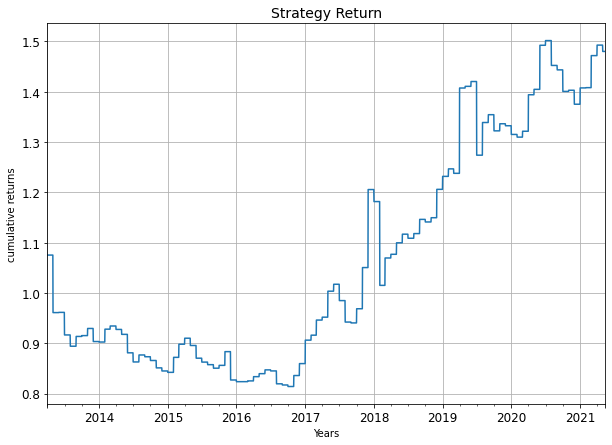

In [8]:
plt.figure(figsize=(10,7));
cumulative_returns.plot();
plt.grid();
plt.title("Strategy Return",fontsize=14)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.xlabel("Years");
plt.ylabel("cumulative returns");


# Draw Down Calculation

In [9]:
max_run=np.maximum.accumulate(cumulative_returns.dropna())
# ensure value isn't below 1
max_run[max_run<1]=1
# draw down percentage
dd=(cumulative_returns)/max_run-1
max_dd=dd.min()*100
print("The maximum draw down is %.2f"%max_dd)

The maximum draw down is -24.30


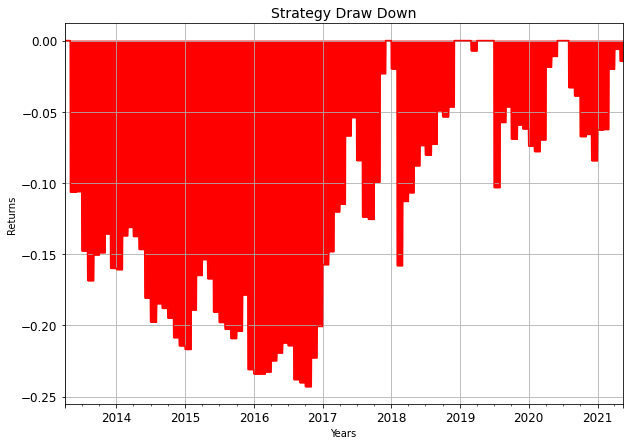

In [10]:
# plot draw down
plt.figure(figsize=(10,7));
dd.plot(color='r');
plt.grid();
plt.fill_between(dd.index,dd.values,color='red')
plt.title("Strategy Draw Down",fontsize=14)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.ylabel("Returns");
plt.xlabel("Years");


## Add Moving Average Filter as a Trend Factor 

    If the price is above 10 days rolling mean of close price , we will hold our position.

In [11]:
BTC['MA_10']=BTC['Last'].rolling(10).mean()
# MA Signals
BTC['MA_Signals']=np.where(BTC['Last'].shift(1)>BTC['MA_10'].shift(1),1,0)
BTC.tail()

,Open,High,Low,Last,Volume,Daily_Change,ToM_Signal,returns,MA_10,MA_Signals
Time,,,,,,,,,,
2021-05-10,59052.00,59603.00,53470.00000,54650.20,62651.664747,-0.074489,0,-0.0,57021.516,1
2021-05-11,54649.69,57424.54,54138.73738,57170.00,36260.027430,0.046108,0,0.0,56968.442,0
2021-05-12,57260.16,58041.00,45000.00000,50321.01,89552.768759,-0.119800,0,-0.0,56191.022,1
2021-05-13,50321.01,51420.72,46897.08000,49522.71,80239.716755,-0.015864,0,-0.0,55569.571,0
2021-05-14,49528.69,51572.00,48873.40000,49836.18,42543.110561,0.006330,0,0.0,55044.916,0


In [12]:
# Strategy return by MA
BTC['returns_MA']=BTC['Daily_Change']*BTC['ToM_Signal'] \
*BTC['MA_Signals']
# cumulative returns
cumulative_returns_MA=((BTC['returns_MA']+1).cumprod())
# strategy returns
strategy_returns_MA=(cumulative_returns_MA.iloc[-1]-1)*100
print("strategy return is %.2f"%strategy_returns)

strategy return is 48.00


In [13]:
BTC.tail()

,Open,High,Low,Last,Volume,Daily_Change,ToM_Signal,returns,MA_10,MA_Signals,returns_MA
Time,,,,,,,,,,,
2021-05-10,59052.00,59603.00,53470.00000,54650.20,62651.664747,-0.074489,0,-0.0,57021.516,1,-0.0
2021-05-11,54649.69,57424.54,54138.73738,57170.00,36260.027430,0.046108,0,0.0,56968.442,0,0.0
2021-05-12,57260.16,58041.00,45000.00000,50321.01,89552.768759,-0.119800,0,-0.0,56191.022,1,-0.0
2021-05-13,50321.01,51420.72,46897.08000,49522.71,80239.716755,-0.015864,0,-0.0,55569.571,0,-0.0
2021-05-14,49528.69,51572.00,48873.40000,49836.18,42543.110561,0.006330,0,0.0,55044.916,0,0.0


In [14]:
# trading days
days=len(cumulative_returns_MA)
# compounded annual growth rate
cagr=(cumulative_returns_MA.iloc[-1]**(252/days)-1)*100
print("the compounded annual growth rate is %.2f"%cagr)

the compounded annual growth rate is 5.46


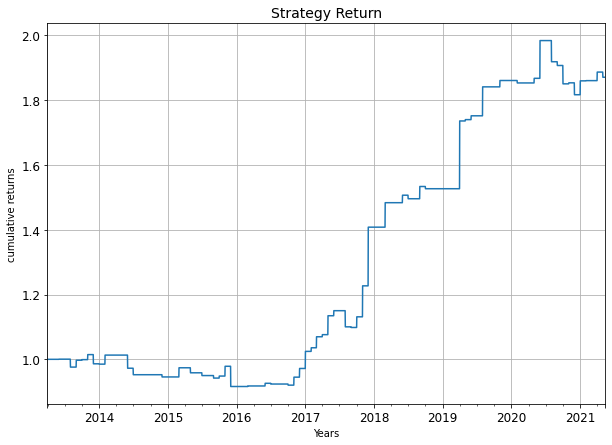

In [15]:
plt.figure(figsize=(10,7));
cumulative_returns_MA.plot();
plt.grid();
plt.title("Strategy Return",fontsize=14)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.xlabel("Years");
plt.ylabel("cumulative returns");

In [16]:
max_run=np.maximum.accumulate(cumulative_returns_MA.dropna())
# ensure value isn't below 1
max_run[max_run<1]=1
# draw down percentage
dd=(cumulative_returns_MA)/max_run-1
max_dd=dd.min()*100
print("The maximum draw down is %.2f"%max_dd)

The maximum draw down is -9.70


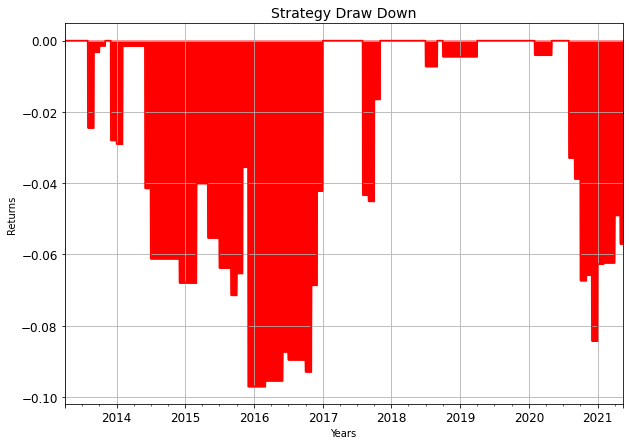

In [17]:
# plot draw down
plt.figure(figsize=(10,7));
dd.plot(color='r');
plt.grid();
plt.fill_between(dd.index,dd.values,color='red')
plt.title("Strategy Draw Down",fontsize=14)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.ylabel("Returns");
plt.xlabel("Years");
